In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

In [3]:
class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=21, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down path of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up path of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.maxpool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [4]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = UNET(in_channels=3, out_channels=21).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr=0.001)

In [5]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [7]:
# Download Pascal VOC dataset
train_dataset = VOCSegmentation(root='.', year='2012', image_set='train', download=True, transform=transform, target_transform=target_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


Using downloaded and verified file: .\VOCtrainval_11-May-2012.tar
Extracting .\VOCtrainval_11-May-2012.tar to .


In [8]:
num_epochs = 5
losses = []

for epoch in range(num_epochs):
    for batch in train_loader:
        inputs, targets = batch
        targets = targets.squeeze(1).long()  # Convert targets to long tensor

        optimizer.zero_grad()

        outputs = unet(inputs.to(device))

        loss = criterion(outputs, targets.to(device))

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # Save the model
    torch.save(unet.state_dict(), f'unet_epoch_{epoch}.pth')

Epoch: 0, Loss: 3.230180501937866
Epoch: 0, Loss: 3.10801100730896
Epoch: 0, Loss: 2.9428341388702393
Epoch: 0, Loss: 2.7719733715057373
Epoch: 0, Loss: 2.620206594467163
Epoch: 0, Loss: 2.5215301513671875
Epoch: 0, Loss: 2.404702663421631
Epoch: 0, Loss: 2.3266263008117676
Epoch: 0, Loss: 2.2532594203948975
Epoch: 0, Loss: 2.187397003173828
Epoch: 0, Loss: 2.1543076038360596
Epoch: 0, Loss: 2.096327066421509
Epoch: 0, Loss: 2.098078966140747
Epoch: 0, Loss: 2.066683769226074
Epoch: 0, Loss: 2.0024545192718506
Epoch: 0, Loss: 1.9914770126342773
Epoch: 0, Loss: 1.9308099746704102
Epoch: 0, Loss: 1.890919804573059
Epoch: 0, Loss: 1.835479497909546
Epoch: 0, Loss: 1.8456300497055054
Epoch: 0, Loss: 1.7869576215744019
Epoch: 0, Loss: 1.7544703483581543
Epoch: 0, Loss: 1.7001161575317383
Epoch: 0, Loss: 1.706959843635559
Epoch: 0, Loss: 1.6418194770812988
Epoch: 0, Loss: 1.6157373189926147
Epoch: 0, Loss: 1.5879029035568237
Epoch: 0, Loss: 1.6782803535461426
Epoch: 0, Loss: 1.56956493854522

KeyboardInterrupt: 

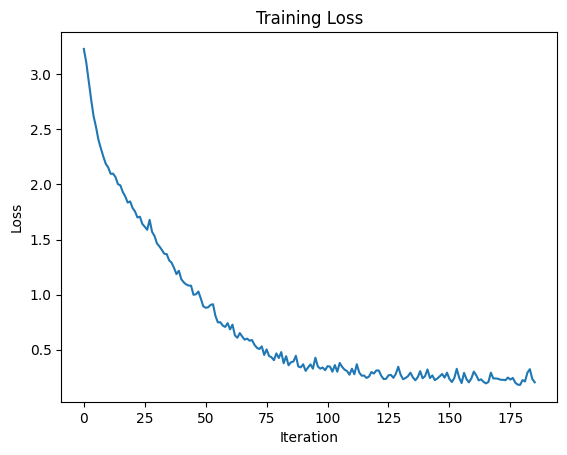

In [9]:
# Plot the loss graph
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
# Function to load the model and continue training
def load_and_continue_training(model_path, start_epoch, num_epochs):
    unet.load_state_dict(torch.load(model_path))
    unet.train()

    for epoch in range(start_epoch, start_epoch + num_epochs):
        for batch in train_loader:
            inputs, targets = batch
            targets = targets.squeeze(1).long()  # Convert targets to long tensor

            optimizer.zero_grad()

            outputs = unet(inputs.to(device))

            loss = criterion(outputs, targets.to(device))

            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            print(f"Epoch: {epoch}, Loss: {loss.item()}")

        # Save the model
        torch.save(unet.state_dict(), f'unet_epoch_{epoch}.pth')

    # Plot the updated loss graph
    plt.plot(losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

# Example usage to continue training
# load_and_continue_training('unet_epoch_4.pth', 5, 5)

### Evaluation and Inference

In [10]:
import numpy as np

def pixel_accuracy(output, target):
    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        correct = (output == target).float()
        acc = correct.sum() / correct.numel()
    return acc

def intersection_and_union(output, target, num_classes):
    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        intersection = output & target
        union = output | target

        intersection_hist = torch.histc(intersection.float(), bins=num_classes, min=0, max=num_classes-1)
        union_hist = torch.histc(union.float(), bins=num_classes, min=0, max=num_classes-1)

    return intersection_hist, union_hist

def mean_iou(intersection_hist, union_hist):
    iou = intersection_hist / union_hist
    miou = torch.mean(iou)
    return miou


Mean Accuracy: 0.9452, Mean IoU: nan


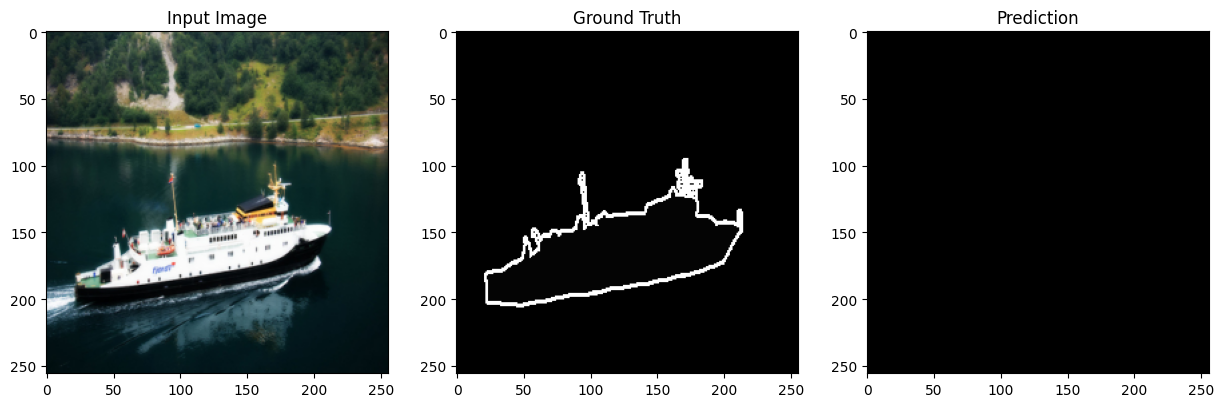

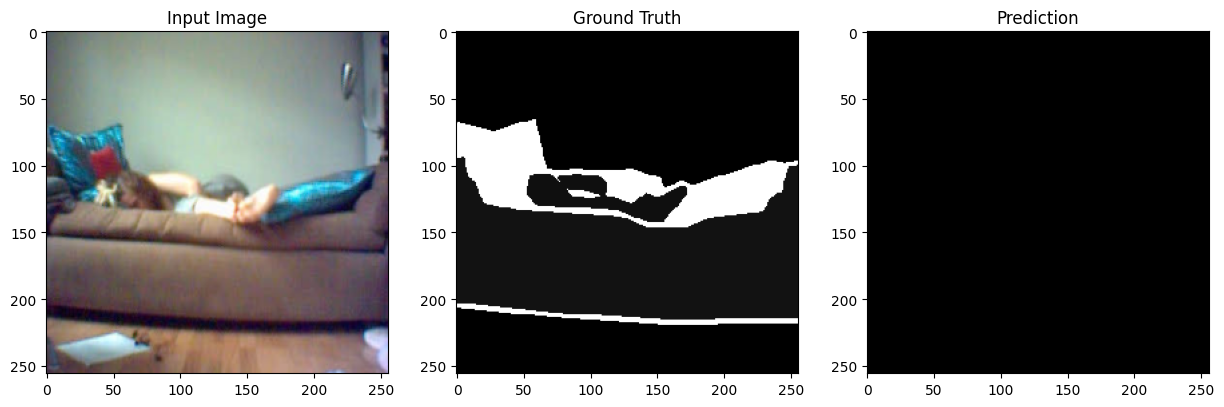

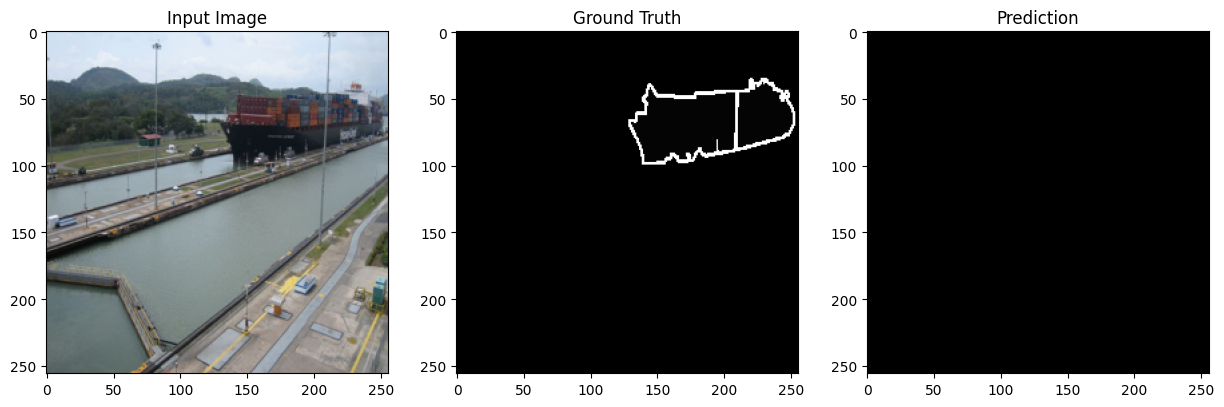

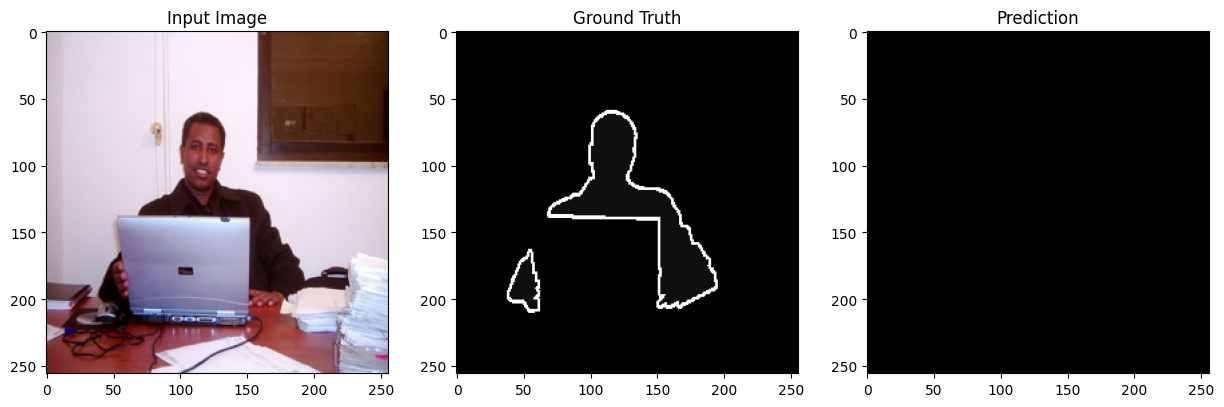

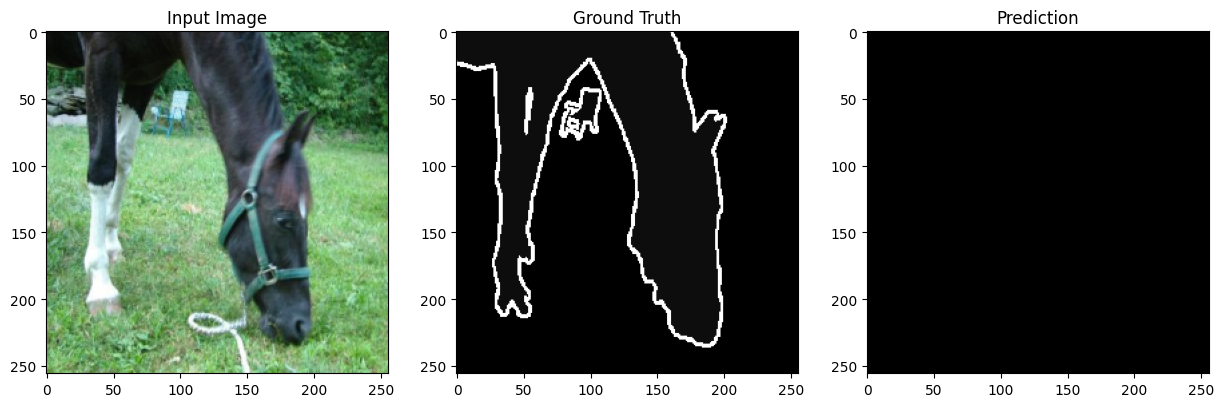

In [11]:
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, device):
    model.eval()
    total_acc = 0
    total_intersection = torch.zeros(21).to(device)
    total_union = torch.zeros(21).to(device)

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.squeeze(1).long().to(device)

            outputs = model(inputs)

            acc = pixel_accuracy(outputs, targets)
            total_acc += acc.item()

            intersection_hist, union_hist = intersection_and_union(outputs, targets, 21)
            total_intersection += intersection_hist
            total_union += union_hist

    mean_acc = total_acc / len(dataloader)
    miou = mean_iou(total_intersection, total_union)

    return mean_acc, miou

def visualize_predictions(model, dataloader, device, num_images=5):
    model.eval()

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            if i >= num_images:
                break
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu()

            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(inputs[0].cpu().permute(1, 2, 0))
            axes[0].set_title("Input Image")
            axes[1].imshow(targets[0].cpu().squeeze(), cmap='gray')
            axes[1].set_title("Ground Truth")
            axes[2].imshow(preds[0].squeeze(), cmap='gray')
            axes[2].set_title("Prediction")
            plt.show()

# Evaluate the model
mean_acc, miou = evaluate_model(unet, train_loader, device)
print(f"Mean Accuracy: {mean_acc:.4f}, Mean IoU: {miou:.4f}")

# Visualize some predictions
visualize_predictions(unet, train_loader, device)


Using downloaded and verified file: .\VOCtrainval_11-May-2012.tar
Extracting .\VOCtrainval_11-May-2012.tar to .
Epoch: 0, Loss: 3.1436519622802734
Epoch: 0, Loss: 3.075023651123047
Epoch: 0, Loss: 2.954864501953125
Epoch: 0, Loss: 2.8002169132232666
Epoch: 0, Loss: 2.6141293048858643
Epoch: 0, Loss: 2.47289776802063
Epoch: 0, Loss: 2.5058271884918213
Epoch: 0, Loss: 2.45782470703125
Epoch: 0, Loss: 2.4300477504730225
Epoch: 0, Loss: 2.2478079795837402
Epoch: 0, Loss: 2.2385146617889404
Epoch: 0, Loss: 2.255417585372925
Epoch: 0, Loss: 2.0727570056915283
Epoch: 0, Loss: 2.13547420501709
Epoch: 0, Loss: 1.9882736206054688
Epoch: 0, Loss: 1.9238594770431519
Epoch: 0, Loss: 1.844947338104248
Epoch: 0, Loss: 1.8237919807434082
Epoch: 0, Loss: 1.7902532815933228
Epoch: 0, Loss: 1.7712894678115845
Epoch: 0, Loss: 1.6826175451278687
Epoch: 0, Loss: 1.675270915031433
Epoch: 0, Loss: 1.612491488456726
Epoch: 0, Loss: 1.577126145362854
Epoch: 0, Loss: 1.5614317655563354
Epoch: 0, Loss: 1.51004517

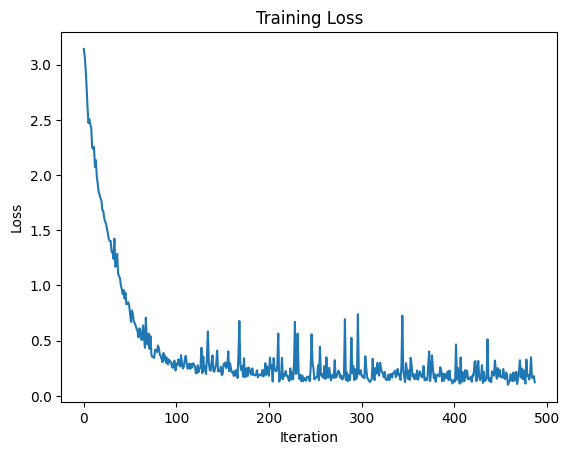

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=21, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down path of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up path of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.maxpool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = UNET(in_channels=3, out_channels=21).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr=0.001)

# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Download Pascal VOC dataset
train_dataset = VOCSegmentation(root='.', year='2012', image_set='train', download=True, transform=transform, target_transform=target_transform)
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)

# Initialize loss list
losses = []

num_epochs = 2

for epoch in range(num_epochs):
    unet.train()
    for batch in train_loader:
        inputs, targets = batch
        targets = targets.squeeze(1).long()  # Convert targets to long tensor

        optimizer.zero_grad()

        outputs = unet(inputs.to(device))

        loss = criterion(outputs, targets.to(device))

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

    # Save the model
    torch.save(unet.state_dict(), f'unet_epoch_{epoch}.pth')

# Plot the loss graph
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [ ]:
# Function to load the model and continue training
def load_and_continue_training(model_path, start_epoch, num_epochs):
    unet.load_state_dict(torch.load(model_path))
    unet.train()

    for epoch in range(start_epoch, start_epoch + num_epochs):
        for batch in train_loader:
            inputs, targets = batch
            targets = targets.squeeze(1).long()  # Convert targets to long tensor

            optimizer.zero_grad()

            outputs = unet(inputs.to(device))

            loss = criterion(outputs, targets.to(device))

            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            print(f"Epoch: {epoch}, Loss: {loss.item()}")

        # Save the model
        torch.save(unet.state_dict(), f'unet_epoch_{epoch}.pth')

    # Plot the updated loss graph
    plt.plot(losses)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

# Example usage to continue training
# load_and_continue_training('unet_epoch_4.pth', 5, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean Accuracy: 0.9451, Mean IoU: 2509848965021696.0000


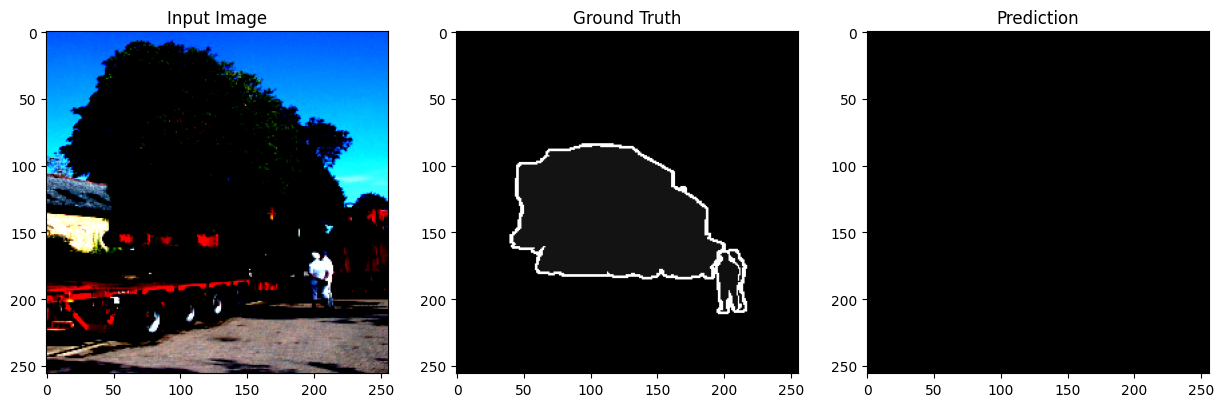

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


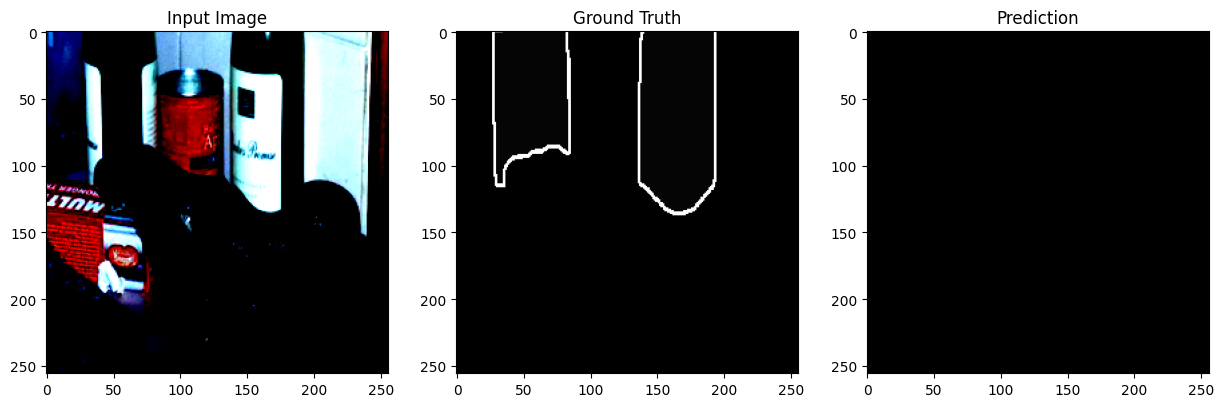

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


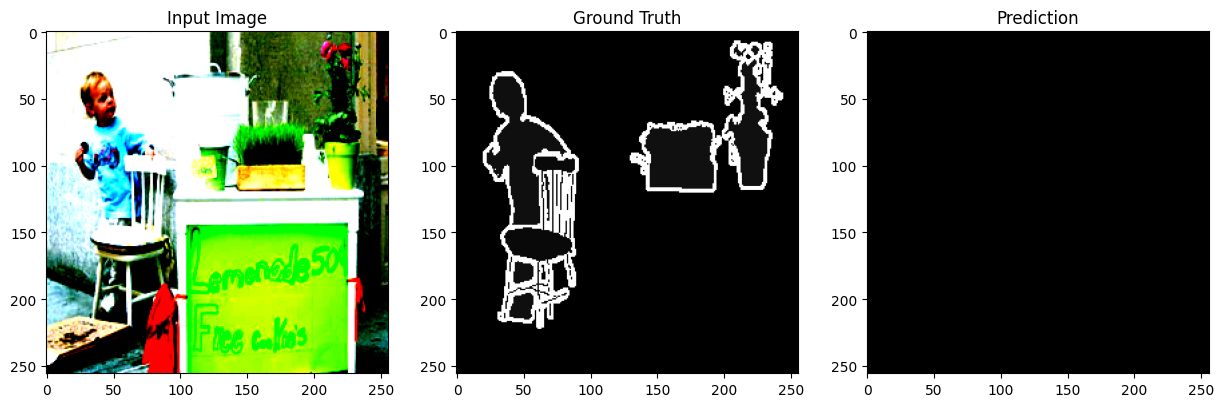

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


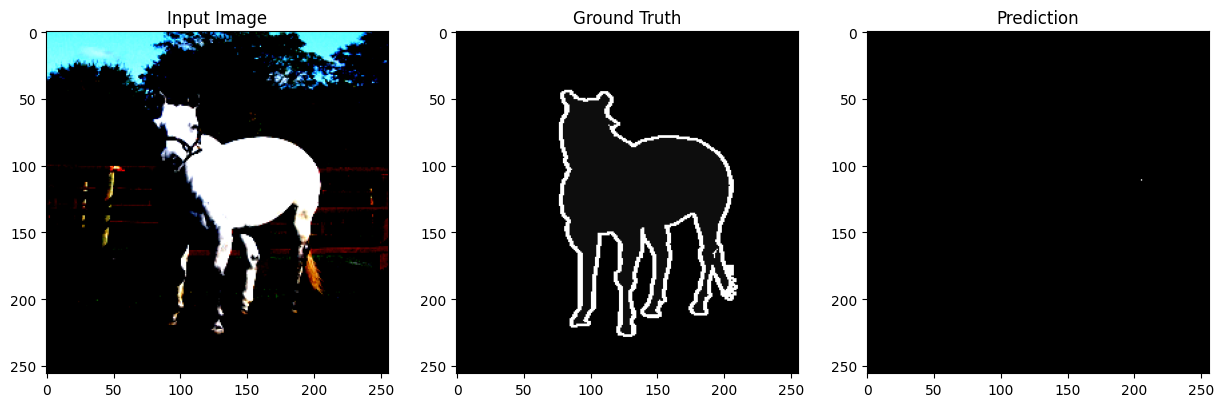

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


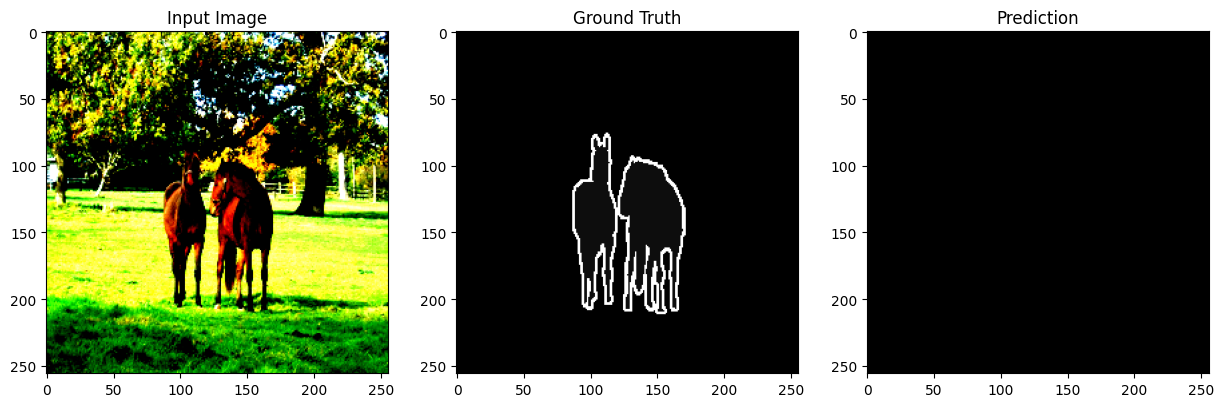

In [3]:
# Pixel accuracy function
def pixel_accuracy(output, target):
    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        correct = (output == target).float()
        acc = correct.sum() / correct.numel()
    return acc

# Intersection and union function
def intersection_and_union(output, target, num_classes):
    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        intersection = (output == target).float()
        union = (output != 0).float() + (target != 0).float() - intersection

        intersection_hist = torch.histc(intersection, bins=num_classes, min=0, max=num_classes-1)
        union_hist = torch.histc(union, bins=num_classes, min=0, max=num_classes-1)

    return intersection_hist, union_hist

# Mean IoU function
def mean_iou(intersection_hist, union_hist):
    iou = intersection_hist / (union_hist + 1e-10)  # Add a small epsilon to avoid division by zero
    miou = torch.mean(iou)
    return miou

# Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    total_acc = 0
    total_intersection = torch.zeros(21).to(device)
    total_union = torch.zeros(21).to(device)

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.squeeze(1).long().to(device)

            outputs = model(inputs)

            acc = pixel_accuracy(outputs, targets)
            total_acc += acc.item()

            intersection_hist, union_hist = intersection_and_union(outputs, targets, 21)
            total_intersection += intersection_hist
            total_union += union_hist

    mean_acc = total_acc / len(dataloader)
    miou = mean_iou(total_intersection, total_union)

    return mean_acc, miou

# Example usage for evaluation
mean_acc, miou = evaluate_model(unet, train_loader, device)
print(f"Mean Accuracy: {mean_acc:.4f}, Mean IoU: {miou:.4f}")

# Visualization function
def visualize_predictions(model, dataloader, device, num_images=5):
    model.eval()

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            if i >= num_images:
                break
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu()

            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(inputs[0].cpu().permute(1, 2, 0).numpy())
            axes[0].set_title("Input Image")
            axes[1].imshow(targets[0].cpu().squeeze(), cmap='gray')
            axes[1].set_title("Ground Truth")
            axes[2].imshow(preds[0].squeeze(), cmap='gray')
            axes[2].set_title("Prediction")
            plt.show()

# Example usage for visualization
visualize_predictions(unet, train_loader, device)

In [ ]:
#########

Using downloaded and verified file: .\VOCtrainval_11-May-2012.tar
Extracting .\VOCtrainval_11-May-2012.tar to .
Using downloaded and verified file: .\VOCtrainval_11-May-2012.tar
Extracting .\VOCtrainval_11-May-2012.tar to .
Epoch: 0, Training Loss: 0.573552947613548
Epoch: 0, Validation Loss: 0.22034231062270393
Epoch: 1, Training Loss: 0.2079910704957657
Epoch: 1, Validation Loss: 0.20007894477568383
Epoch: 2, Training Loss: 0.1990331366169648
Epoch: 2, Validation Loss: 0.20401248305050795
Epoch: 3, Training Loss: 0.19650524152351206
Epoch: 3, Validation Loss: 0.1960462804976081
Epoch: 4, Training Loss: 0.1938423438944289
Epoch: 4, Validation Loss: 0.19233173953969618
Epoch: 5, Training Loss: 0.19318807821293346
Epoch: 5, Validation Loss: 0.19190467296799352
Epoch: 6, Training Loss: 0.19047140708712282
Epoch: 6, Validation Loss: 0.19058029467532459
Epoch: 7, Training Loss: 0.1902266129484919
Epoch: 7, Validation Loss: 0.19014395022195232
Epoch: 8, Training Loss: 0.1914992387727147
Epo

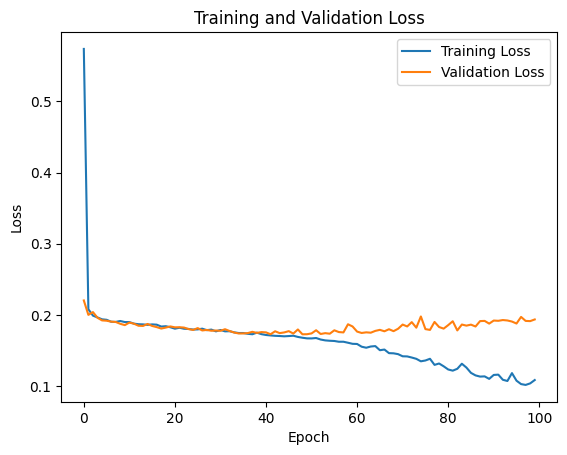

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=21, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down path of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up path of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.maxpool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = UNET(in_channels=3, out_channels=21).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr=0.001)

# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Download Pascal VOC dataset
train_dataset = VOCSegmentation(root='.', year='2012', image_set='train', download=True, transform=transform, target_transform=target_transform)
val_dataset = VOCSegmentation(root='.', year='2012', image_set='val', download=True, transform=transform, target_transform=target_transform)
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=6, shuffle=False)

# Initialize loss list
losses = []
val_losses = []

num_epochs = 100  # Increase the number of epochs
best_val_loss = float('inf')

for epoch in range(num_epochs):
    unet.train()
    epoch_loss = 0

    for batch in train_loader:
        inputs, targets = batch
        targets = targets.squeeze(1).long()  # Convert targets to long tensor

        optimizer.zero_grad()

        outputs = unet(inputs.to(device))

        loss = criterion(outputs, targets.to(device))
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    losses.append(epoch_loss / len(train_loader))
    print(f"Epoch: {epoch}, Training Loss: {epoch_loss / len(train_loader)}")

    # Validation step
    unet.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            targets = targets.squeeze(1).long()  # Convert targets to long tensor

            outputs = unet(inputs.to(device))

            loss = criterion(outputs, targets.to(device))
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch: {epoch}, Validation Loss: {val_loss / len(val_loader)}")

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(unet.state_dict(), 'best_unet.pth')

# Plot the loss graph
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Function to load the model and continue training
def load_and_continue_training(model_path, start_epoch, num_epochs):
    unet.load_state_dict(torch.load(model_path))
    unet.train()

    for epoch in range(start_epoch, start_epoch + num_epochs):
        epoch_loss = 0

        for batch in train_loader:
            inputs, targets = batch
            targets = targets.squeeze(1).long()  # Convert targets to long tensor

            optimizer.zero_grad()

            outputs = unet(inputs.to(device))

            loss = criterion(outputs, targets.to(device))
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

        losses.append(epoch_loss / len(train_loader))
        print(f"Epoch: {epoch}, Training Loss: {epoch_loss / len(train_loader)}")

        # Validation step
        unet.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch
                targets = targets.squeeze(1).long()  # Convert targets to long tensor

                outputs = unet(inputs.to(device))

                loss = criterion(outputs, targets.to(device))
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch: {epoch}, Validation Loss: {val_loss / len(val_loader)}")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(unet.state_dict(), 'best_unet.pth')

    # Plot the updated loss graph
    plt.plot(losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Example usage to continue training
# load_and_continue_training('unet_epoch_4.pth', 5, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean Accuracy: 0.9446, Mean IoU: 2500374267166720.0000


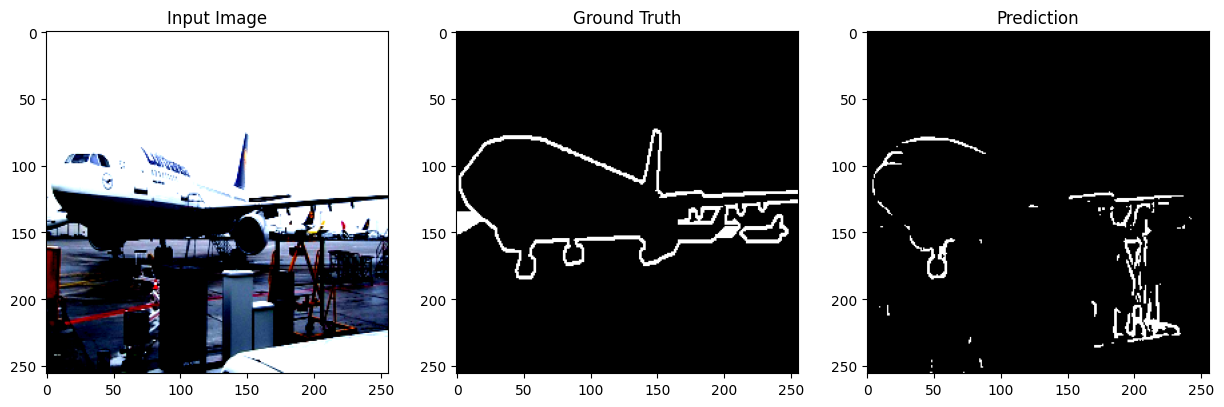

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


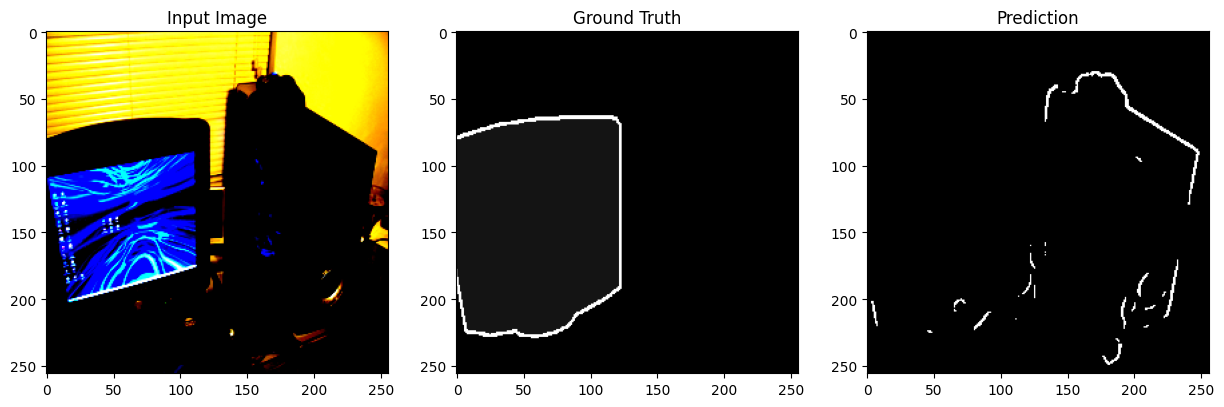

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


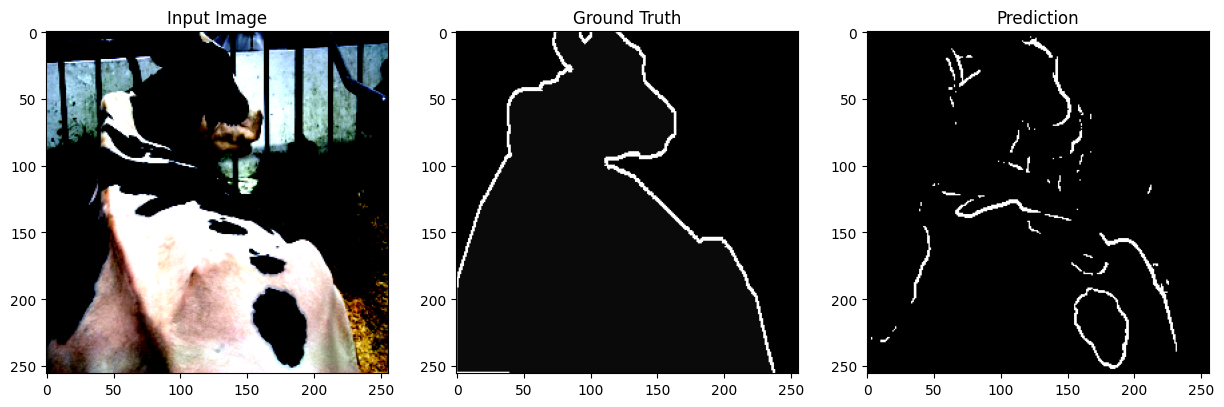

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


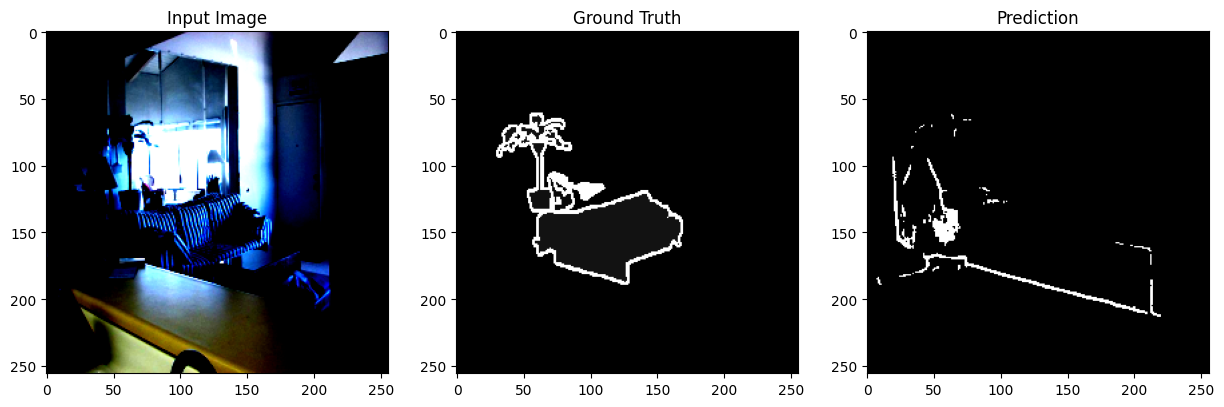

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


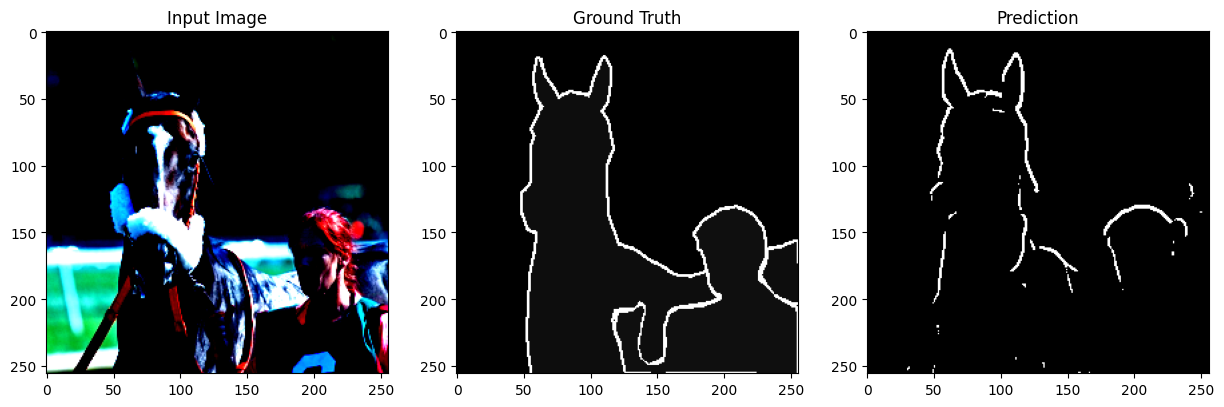

In [2]:
# Pixel accuracy function
def pixel_accuracy(output, target):
    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        correct = (output == target).float()
        acc = correct.sum() / correct.numel()
    return acc

# Intersection and union function
def intersection_and_union(output, target, num_classes):
    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        intersection = (output == target).float()
        union = (output != 0).float() + (target != 0).float() - intersection

        intersection_hist = torch.histc(intersection, bins=num_classes, min=0, max=num_classes-1)
        union_hist = torch.histc(union, bins=num_classes, min=0, max=num_classes-1)

    return intersection_hist, union_hist

# Mean IoU function
def mean_iou(intersection_hist, union_hist):
    iou = intersection_hist / (union_hist + 1e-10)  # Add a small epsilon to avoid division by zero
    miou = torch.mean(iou)
    return miou

# Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    total_acc = 0
    total_intersection = torch.zeros(21).to(device)
    total_union = torch.zeros(21).to(device)

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.squeeze(1).long().to(device)

            outputs = model(inputs)

            acc = pixel_accuracy(outputs, targets)
            total_acc += acc.item()

            intersection_hist, union_hist = intersection_and_union(outputs, targets, 21)
            total_intersection += intersection_hist
            total_union += union_hist

    mean_acc = total_acc / len(dataloader)
    miou = mean_iou(total_intersection, total_union)

    return mean_acc, miou

# Example usage for evaluation
mean_acc, miou = evaluate_model(unet, val_loader, device)
print(f"Mean Accuracy: {mean_acc:.4f}, Mean IoU: {miou:.4f}")

# Visualization function
def visualize_predictions(model, dataloader, device, num_images=5):
    model.eval()

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            if i >= num_images:
                break
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu()

            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(inputs[0].cpu().permute(1, 2, 0).numpy())
            axes[0].set_title("Input Image")
            axes[1].imshow(targets[0].cpu().squeeze(), cmap='gray')
            axes[1].set_title("Ground Truth")
            axes[2].imshow(preds[0].squeeze(), cmap='gray')
            axes[2].set_title("Prediction")
            plt.show()

# Example usage for visualization
visualize_predictions(unet, val_loader, device)

In [ ]:
####################
####################

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.5):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=21, features=[64, 128, 256, 512], dropout=0.5):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down path of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature, dropout))
            in_channels = feature

        # Up path of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature, dropout))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2, dropout)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.maxpool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = UNET(in_channels=3, out_channels=21).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

# Transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Download Pascal VOC dataset
train_dataset = VOCSegmentation(root='.', year='2012', image_set='train', download=True, transform=transform, target_transform=target_transform)
val_dataset = VOCSegmentation(root='.', year='2012', image_set='val', download=True, transform=transform, target_transform=target_transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

C:\Users\Sandesh\Desktop\Projects\ForkLift\forklift\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Using downloaded and verified file: .\VOCtrainval_11-May-2012.tar
Extracting .\VOCtrainval_11-May-2012.tar to .
Using downloaded and verified file: .\VOCtrainval_11-May-2012.tar
Extracting .\VOCtrainval_11-May-2012.tar to .


In [2]:
# Initialize loss list
losses = []
val_losses = []

num_epochs = 50  # Increase the number of epochs
best_val_loss = float('inf')

for epoch in range(num_epochs):
    unet.train()
    epoch_loss = 0

    for batch in train_loader:
        inputs, targets = batch
        targets = targets.squeeze(1).long()  # Convert targets to long tensor

        optimizer.zero_grad()

        outputs = unet(inputs.to(device))

        loss = criterion(outputs, targets.to(device))
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    losses.append(epoch_loss / len(train_loader))
    print(f"Epoch: {epoch}, Training Loss: {epoch_loss / len(train_loader)}")

    # Validation step
    unet.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            targets = targets.squeeze(1).long()  # Convert targets to long tensor

            outputs = unet(inputs.to(device))

            loss = criterion(outputs, targets.to(device))
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch: {epoch}, Validation Loss: {val_loss / len(val_loader)}")
    
    # Step the scheduler
    scheduler.step(val_loss / len(val_loader))

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(unet.state_dict(), 'best_unet.pth')

# Plot the loss graph
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Epoch: 0, Training Loss: 1.1381836212847545
Epoch: 0, Validation Loss: 0.3386315691929597
Epoch: 1, Training Loss: 0.31120448203190515
Epoch: 1, Validation Loss: 0.23500063049269246
Epoch: 2, Training Loss: 0.2540585614092972
Epoch: 2, Validation Loss: 0.22127106572900498
Epoch: 3, Training Loss: 0.23787857219576836
Epoch: 3, Validation Loss: 0.21604001358315184
Epoch: 4, Training Loss: 0.2306856351054233
Epoch: 4, Validation Loss: 0.2130838740657974
Epoch: 5, Training Loss: 0.2255415009415668
Epoch: 5, Validation Loss: 0.21230547899728294
Epoch: 6, Training Loss: 0.22297027221192484
Epoch: 6, Validation Loss: 0.2110298018042858
Epoch: 7, Training Loss: 0.22101413669145625
Epoch: 7, Validation Loss: 0.2104931020147198
Epoch: 8, Training Loss: 0.219394709105077
Epoch: 8, Validation Loss: 0.20983390911267355
Epoch: 9, Training Loss: 0.217562904500443
Epoch: 9, Validation Loss: 0.2127537095284724
Epoch: 10, Training Loss: 0.21643094637471696
Epoch: 10, Validation Loss: 0.21979148129185477

KeyboardInterrupt: 

In [ ]:
# Function to load the model and continue training
def load_and_continue_training(model_path, start_epoch, num_epochs):
    unet.load_state_dict(torch.load(model_path))
    unet.train()

    for epoch in range(start_epoch, start_epoch + num_epochs):
        epoch_loss = 0

        for batch in train_loader:
            inputs, targets = batch
            targets = targets.squeeze(1).long()  # Convert targets to long tensor

            optimizer.zero_grad()

            outputs = unet(inputs.to(device))

            loss = criterion(outputs, targets.to(device))
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

        losses.append(epoch_loss / len(train_loader))
        print(f"Epoch: {epoch}, Training Loss: {epoch_loss / len(train_loader)}")

        # Validation step
        unet.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch
                targets = targets.squeeze(1).long()  # Convert targets to long tensor

                outputs = unet(inputs.to(device))

                loss = criterion(outputs, targets.to(device))
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch: {epoch}, Validation Loss: {val_loss / len(val_loader)}")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(unet.state_dict(), 'best_unet.pth')

    # Plot the updated loss graph
    plt.plot(losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Example usage to continue training
# load_and_continue_training('unet_epoch_4.pth', 5, 5)

In [ ]:
# Pixel accuracy function
def pixel_accuracy(output, target):
    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        correct = (output == target).float()
        acc = correct.sum() / correct.numel()
    return acc

# Intersection and union function
def intersection_and_union(output, target, num_classes):
    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        intersection = (output == target).float()
        union = (output != 0).float() + (target != 0).float() - intersection

        intersection_hist = torch.histc(intersection, bins=num_classes, min=0, max=num_classes-1)
        union_hist = torch.histc(union, bins=num_classes, min=0, max=num_classes-1)

    return intersection_hist, union_hist

# Mean IoU function
def mean_iou(intersection_hist, union_hist):
    iou = intersection_hist / (union_hist + 1e-10)  # Add a small epsilon to avoid division by zero
    miou = torch.mean(iou)
    return miou

# Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    total_acc = 0
    total_intersection_hist = torch.zeros(21)
    total_union_hist = torch.zeros(21)

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device).squeeze(1).long()

            outputs = model(inputs)

            acc = pixel_accuracy(outputs, targets)
            total_acc += acc.item()

            intersection_hist, union_hist = intersection_and_union(outputs, targets, 21)
            total_intersection_hist += intersection_hist
            total_union_hist += union_hist

    mean_acc = total_acc / len(dataloader)
    mean_iou_value = mean_iou(total_intersection_hist, total_union_hist)

    return mean_acc, mean_iou_value

# Evaluate the model
mean_acc, mean_iou_value = evaluate_model(unet, val_loader, device)
print(f"Mean Pixel Accuracy: {mean_acc:.4f}, Mean IoU: {mean_iou_value:.4f}")

# Visualization function
def visualize_predictions(model, dataloader, device, num_images=5):
    model.eval()

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            if i >= num_images:
                break
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu()

            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(inputs[0].cpu().permute(1, 2, 0).numpy())
            axes[0].set_title("Input Image")
            axes[1].imshow(targets[0].cpu().squeeze(), cmap='gray')
            axes[1].set_title("Ground Truth")
            axes[2].imshow(preds[0].squeeze(), cmap='gray')
            axes[2].set_title("Prediction")
            plt.show()

# Example usage for visualization
visualize_predictions(unet, val_loader, device)

In [ ]:
# Pixel accuracy function
def pixel_accuracy(output, target):
    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        correct = (output == target).float()
        acc = correct.sum() / correct.numel()
    return acc

# Intersection and union function
def intersection_and_union(output, target, num_classes):
    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        intersection = (output == target).float()
        union = (output != 0).float() + (target != 0).float() - intersection

        intersection_hist = torch.histc(intersection, bins=num_classes, min=0, max=num_classes-1)
        union_hist = torch.histc(union, bins=num_classes, min=0, max=num_classes-1)

    return intersection_hist, union_hist

# Mean IoU function
def mean_iou(intersection_hist, union_hist):
    iou = intersection_hist / (union_hist + 1e-10)  # Add a small epsilon to avoid division by zero
    miou = torch.mean(iou)
    return miou

# Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    total_acc = 0
    total_intersection_hist = torch.zeros(21)
    total_union_hist = torch.zeros(21)

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device).squeeze(1).long()

            outputs = model(inputs)

            acc = pixel_accuracy(outputs, targets)
            total_acc += acc.item()

            intersection_hist, union_hist = intersection_and_union(outputs, targets, 21)
            total_intersection_hist += intersection_hist
            total_union_hist += union_hist

    mean_acc = total_acc / len(dataloader)
    mean_iou_value = mean_iou(total_intersection_hist, total_union_hist)

    return mean_acc, mean_iou_value

# Evaluate the model
mean_acc, mean_iou_value = evaluate_model(unet, val_loader, device)
print(f"Mean Pixel Accuracy: {mean_acc:.4f}, Mean IoU: {mean_iou_value:.4f}")

# Pascal VOC color palette
VOC_COLOR_PALETTE = np.array([
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
    [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
    [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
], dtype=np.uint8)

def decode_segmap(label_mask):
    r = np.zeros_like(label_mask).astype(np.uint8)
    g = np.zeros_like(label_mask).astype(np.uint8)
    b = np.zeros_like(label_mask).astype(np.uint8)
    
    for label in range(0, 21):
        idx = label_mask == label
        r[idx] = VOC_COLOR_PALETTE[label, 0]
        g[idx] = VOC_COLOR_PALETTE[label, 1]
        b[idx] = VOC_COLOR_PALETTE[label, 2]
    
    rgb = np.stack([r, g, b], axis=2)
    return rgb

# Visualization function
def visualize_predictions(model, dataloader, device, num_images=5):
    model.eval()

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            if i >= num_images:
                break
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(inputs[0].cpu().permute(1, 2, 0).numpy())
            axes[0].set_title("Input Image")
            axes[1].imshow(decode_segmap(targets[0].cpu().numpy()))
            axes[1].set_title("Ground Truth")
            axes[2].imshow(decode_segmap(preds[0]))
            axes[2].set_title("Prediction")
            plt.show()

# Example usage for visualization
visualize_predictions(unet, val_loader, device)

In [ ]:
######
#####
#####

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.5):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=21, features=[64, 128, 256, 512], dropout=0.5):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down path of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature, dropout=dropout))
            in_channels = feature

        # Up path of UNET
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature, dropout=dropout))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2, dropout=dropout)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.maxpool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = UNET(in_channels=3, out_channels=21, dropout=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(unet.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

# Transformations without data augmentation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

target_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Download Pascal VOC dataset
train_dataset = VOCSegmentation(root='.', year='2012', image_set='train', download=True, transform=transform, target_transform=target_transform)
val_dataset = VOCSegmentation(root='.', year='2012', image_set='val', download=True, transform=transform, target_transform=target_transform)
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=6, shuffle=False)

C:\Users\Sandesh\Desktop\Projects\ForkLift\forklift\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Using downloaded and verified file: .\VOCtrainval_11-May-2012.tar
Extracting .\VOCtrainval_11-May-2012.tar to .
Using downloaded and verified file: .\VOCtrainval_11-May-2012.tar
Extracting .\VOCtrainval_11-May-2012.tar to .


Epoch: 0, Training Loss: 0.8101977981993409
Epoch: 0, Validation Loss: 0.2221841338313808
Epoch: 1, Training Loss: 0.23722923156179365
Epoch: 1, Validation Loss: 0.21052129378865572
Epoch: 2, Training Loss: 0.21474521604107052
Epoch: 2, Validation Loss: 0.2039904573485871
Epoch: 3, Training Loss: 0.2057992892614642
Epoch: 3, Validation Loss: 0.19441636457792982
Epoch: 4, Training Loss: 0.20276721420346713
Epoch: 4, Validation Loss: 0.20281996981294687
Epoch: 5, Training Loss: 0.2008883074292394
Epoch: 5, Validation Loss: 0.19578116143907398
Epoch: 6, Training Loss: 0.19860721883348753
Epoch: 6, Validation Loss: 0.19602464662849411
Epoch: 7, Training Loss: 0.19819270278953138
Epoch: 7, Validation Loss: 0.1943959411510751
Epoch: 8, Training Loss: 0.19673749612125216
Epoch: 8, Validation Loss: 0.19324168692196697
Epoch: 9, Training Loss: 0.19538898537027055
Epoch: 9, Validation Loss: 0.19339818365810332
Epoch: 10, Training Loss: 0.19492941035232583
Epoch: 10, Validation Loss: 0.1934753238

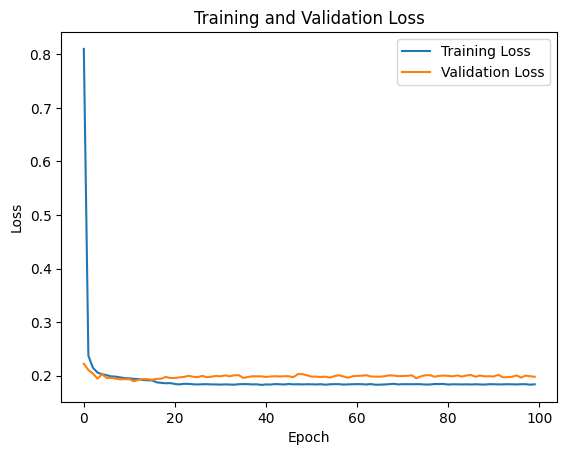

In [2]:
# Initialize loss list
losses = []
val_losses = []

num_epochs = 100  # Increase the number of epochs
best_val_loss = float('inf')

for epoch in range(num_epochs):
    unet.train()
    epoch_loss = 0

    for batch in train_loader:
        inputs, targets = batch
        targets = targets.squeeze(1).long()  # Convert targets to long tensor

        optimizer.zero_grad()

        outputs = unet(inputs.to(device))

        loss = criterion(outputs, targets.to(device))
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

    losses.append(epoch_loss / len(train_loader))
    print(f"Epoch: {epoch}, Training Loss: {epoch_loss / len(train_loader)}")

    # Validation step
    unet.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            inputs, targets = batch
            targets = targets.squeeze(1).long()  # Convert targets to long tensor

            outputs = unet(inputs.to(device))

            loss = criterion(outputs, targets.to(device))
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch: {epoch}, Validation Loss: {val_loss / len(val_loader)}")
    
    # Step the scheduler
    scheduler.step(val_loss / len(val_loader))

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(unet.state_dict(), 'best_unet.pth')

    # Save the model
    torch.save(unet.state_dict(), f'unet_epoch_{epoch}.pth')

# Plot the loss graph
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Function to load the model and continue training
def load_and_continue_training(model_path, start_epoch, num_epochs):
    unet.load_state_dict(torch.load(model_path))
    unet.train()

    for epoch in range(start_epoch, start_epoch + num_epochs):
        epoch_loss = 0

        for batch in train_loader:
            inputs, targets = batch
            targets = targets.squeeze(1).long()  # Convert targets to long tensor

            optimizer.zero_grad()

            outputs = unet(inputs.to(device))

            loss = criterion(outputs, targets.to(device))
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

        losses.append(epoch_loss / len(train_loader))
        print(f"Epoch: {epoch}, Training Loss: {epoch_loss / len(train_loader)}")

        # Validation step
        unet.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch
                targets = targets.squeeze(1).long()  # Convert targets to long tensor

                outputs = unet(inputs.to(device))

                loss = criterion(outputs, targets.to(device))
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch: {epoch}, Validation Loss: {val_loss / len(val_loader)}")

        # Save the best model
        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     torch.save(unet.state_dict(), 'best_unet.pth')

        # Save the model
        torch.save(unet.state_dict(), f'unet_epoch_{epoch}.pth')

    # Plot the updated loss graph
    plt.plot(losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

# Example usage to continue training
# load_and_continue_training('unet_epoch_4.pth', 5, 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Mean Pixel Accuracy: 0.9446, Mean IoU: 2499827195707392.0000


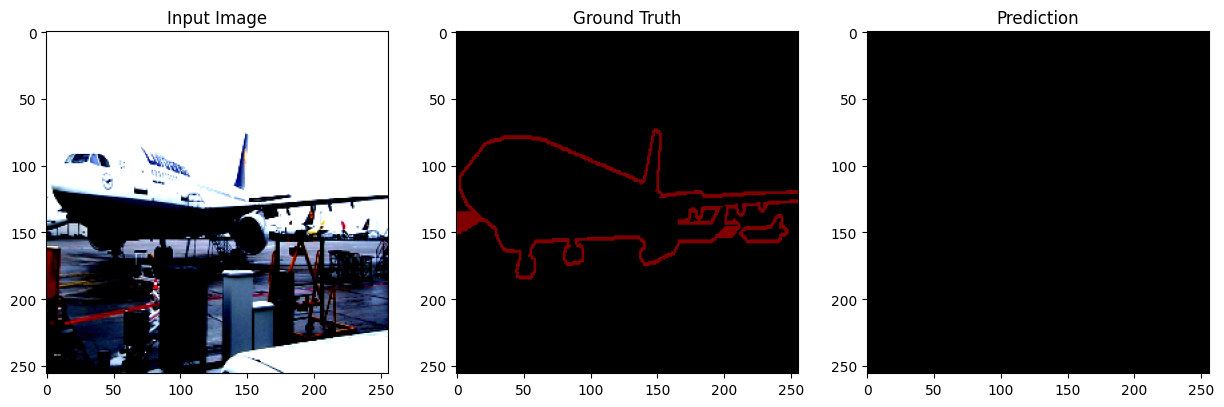

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


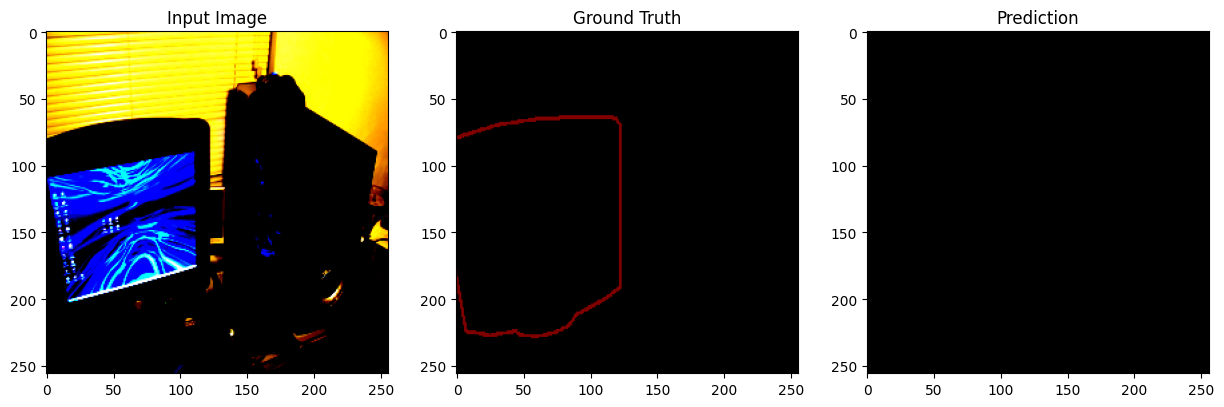

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


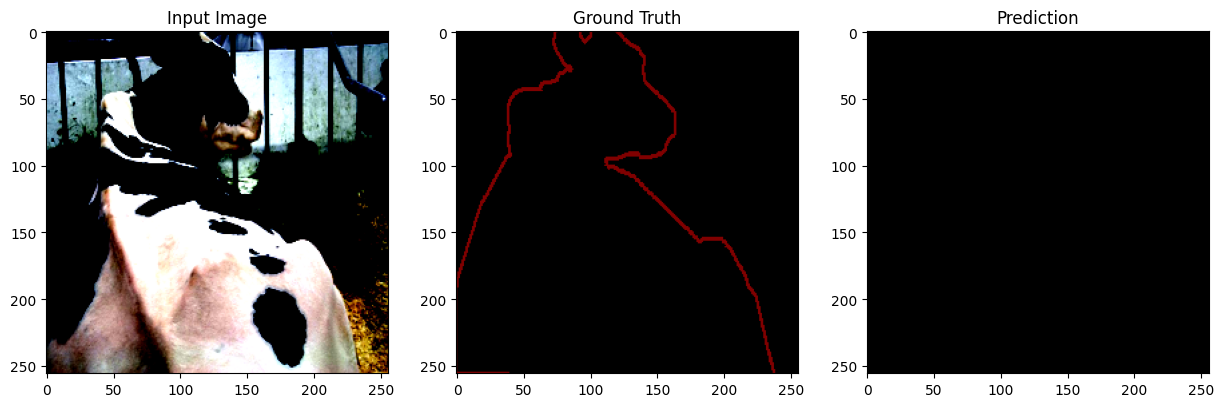

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


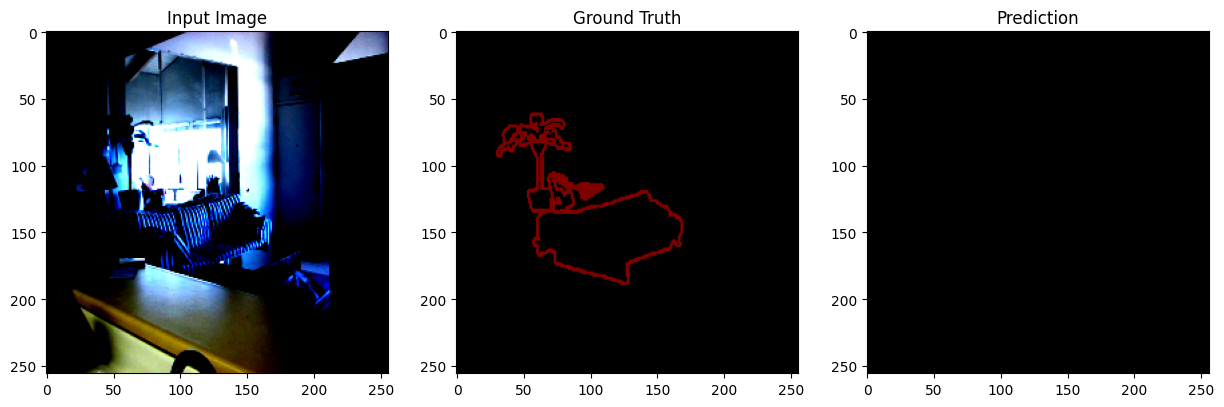

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


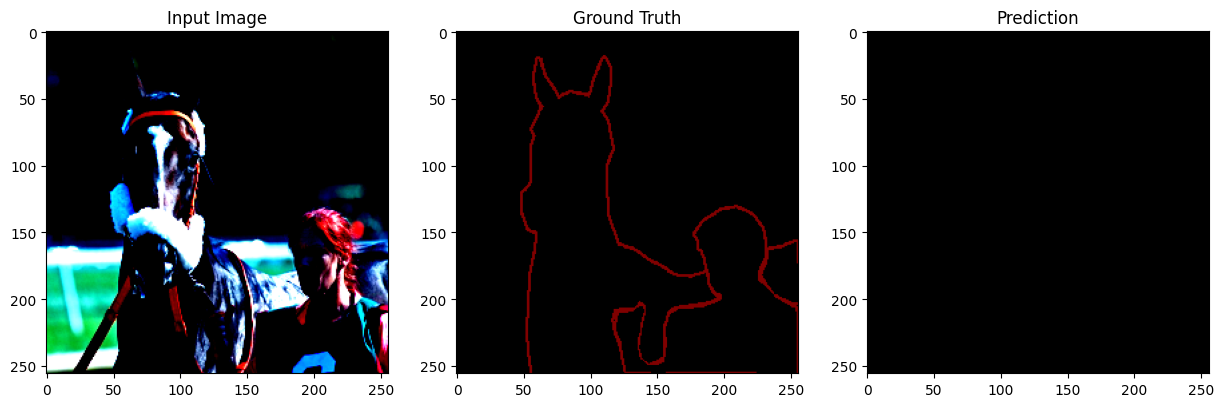

In [6]:
# Pixel accuracy function
def pixel_accuracy(output, target):
    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        correct = (output == target).float()
        acc = correct.sum() / correct.numel()
    return acc

# Intersection and union function
def intersection_and_union(output, target, num_classes):
    with torch.no_grad():
        output = torch.argmax(output, dim=1)
        intersection = (output == target).float()
        union = (output != 0).float() + (target != 0).float() - intersection

        intersection_hist = torch.histc(intersection, bins=num_classes, min=0, max=num_classes-1).to(device)
        union_hist = torch.histc(union, bins=num_classes, min=0, max=num_classes-1).to(device)

    return intersection_hist, union_hist

# Mean IoU function
def mean_iou(intersection_hist, union_hist):
    iou = intersection_hist / (union_hist + 1e-10)  # Add a small epsilon to avoid division by zero
    miou = torch.mean(iou)
    return miou

# Evaluation function
def evaluate_model(model, dataloader, device):
    model.eval()
    total_acc = 0
    total_intersection_hist = torch.zeros(21).to(device)
    total_union_hist = torch.zeros(21).to(device)

    with torch.no_grad():
        for inputs, targets in dataloader:
            targets = targets.squeeze(1).long()
            outputs = model(inputs.to(device))

            acc = pixel_accuracy(outputs, targets.to(device))
            total_acc += acc.item()

            intersection_hist, union_hist = intersection_and_union(outputs, targets.to(device), num_classes=21)
            total_intersection_hist += intersection_hist
            total_union_hist += union_hist

    mean_acc = total_acc / len(dataloader)
    mean_iou_value = mean_iou(total_intersection_hist, total_union_hist)

    return mean_acc, mean_iou_value

# Evaluate the model
mean_acc, mean_iou_value = evaluate_model(unet, val_loader, device)
print(f"Mean Pixel Accuracy: {mean_acc:.4f}, Mean IoU: {mean_iou_value:.4f}")

# Pascal VOC color palette
VOC_COLOR_PALETTE = np.array([
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
    [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
    [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
], dtype=np.uint8)

def decode_segmap(label_mask):
    r = np.zeros_like(label_mask).astype(np.uint8)
    g = np.zeros_like(label_mask).astype(np.uint8)
    b = np.zeros_like(label_mask).astype(np.uint8)
    
    for label in range(0, 21):
        idx = label_mask == label
        r[idx] = VOC_COLOR_PALETTE[label, 0]
        g[idx] = VOC_COLOR_PALETTE[label, 1]
        b[idx] = VOC_COLOR_PALETTE[label, 2]
    
    rgb = np.stack([r, g, b], axis=2)
    return rgb

# Visualization function
def visualize_predictions(model, dataloader, device, num_images=5):
    model.eval()

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(dataloader):
            if i >= num_images:
                break
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            axes[0].imshow(inputs[0].cpu().permute(1, 2, 0).numpy())
            axes[0].set_title("Input Image")
            axes[1].imshow(decode_segmap(targets[0].squeeze().cpu().numpy()))
            axes[1].set_title("Ground Truth")
            axes[2].imshow(decode_segmap(preds[0]))
            axes[2].set_title("Prediction")
            plt.show()

# Example usage for visualization
visualize_predictions(unet, val_loader, device)